# Look for valid questions in comments
We've looked in prior work for valid questions in comment data based on "standalone" questions ([here](sample_label_comment_questions.ipynb)) but the data sparsity is pretty bad, i.e. about 15000/940000 $\sim$ 2% of comments have a valid question.

Let's expand our search and get all questions that:

1. occur at the beginning of a comment
2. receive at least one reply from the OP or from another commenter

## Load data

In [1]:
import pandas as pd
import os
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_zipped_json_data
data_dir = '../../data/reddit_data/'
comment_data_files = list(filter(lambda x: x.startswith('subreddit_comments'), os.listdir(data_dir)))
comment_data_files = list(map(lambda x: os.path.join(data_dir, x), comment_data_files))
comment_data = pd.concat(list(map(lambda x: load_zipped_json_data(x), comment_data_files)), axis=0)
display(comment_data.head())
print(f'{comment_data.shape[0]} comments')

ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached
ending data collection early because error Compressed file ended before the end-of-stream marker was reached


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit
0,grumpypantsoldman,None,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,t3_9t3n27,14,AmItheAsshole
1,unknown_salmon,None,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,t3_9t1u2e,2,Advice
2,vld-s,None,t2_14p3sr,YNTA. He made you uncomfortable and you distan...,1541030467,False,e8tkkjt,t3_9t3xz3,3,AmItheAsshole
3,Prepperpoints2Ponder,None,t2_11lpfa,Manufacturing here. Me and spouse will be payi...,1541030470,False,e8tkkns,t3_9t2e8e,2,personalfinance
4,juliej891,None,t2_1mwezovi,I think you’re going to go out of your way to ...,1541030493,False,e8tklij,t3_9t4afp,1,Advice


4371692 comments


In [3]:
## submission
submission_data = load_zipped_json_data('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz')
display(submission_data.head())

,author,author_flair_text,created_utc,edited,id,num_comments,score,selftext,subreddit,title,category,author_fullname
0,deepsouthsloth,None,1514764840,False,7nby0l,7,1,26M/married/2 kids\n\nEmployer match is 50% up...,personalfinance,Should I continue with 401k despite terrible e...,NaN,NaN
1,CapableCounteroffer,None,1514764890,False,7nby5t,5,0,"On November 24th, I called AT&amp;T to inquire...",legaladvice,[FL] Issue getting AT&amp;T to pay early termi...,NaN,NaN
2,pinkcrayon69,None,1514764948,False,7nbybf,9,3,I live in south OC but I need to move out of m...,personalfinance,I need to move out in a month. What should I p...,NaN,NaN
3,bobshellby,Needs 64bit Windows...,1514765040,False,7nbykz,6,0,Are there keycaps for the Microsoft wireless k...,pcmasterrace,Keyboard keycap help,NaN,NaN
4,j0sh135742,None,1514765064,1514765420.0,7nbyno,4,0,"So in MGL Part 1, Title 15, Chapter 94G, Secti...",legaladvice,Quick question about Medical Marijuana.,NaN,NaN


In [41]:
## combine data
comment_data = comment_data.assign(**{'parent_id':comment_data.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])})
submission_data.rename(columns={'id' : 'parent_id', 'created_utc' : 'parent_created', 'selftext' : 'parent_text', 'title' : 'parent_title', 'edited' : 'parent_edited', 'author' : 'parent_author'}, inplace=True)
comment_submission_data = pd.merge(
    comment_data, 
    submission_data.loc[:, ['parent_id', 'parent_created', 'parent_text', 'parent_title', 'parent_edited', 'parent_author']],
    on='parent_id'
)
# remove duplicate questions
comment_submission_data.drop_duplicates(['parent_id', 'body'], inplace=True)

In [42]:
print(f'{comment_submission_data.shape[0]} comments total')

4193267 comments total


In [12]:
## extract questions
from data_helpers import extract_questions_all_data
comment_data = comment_data.assign(**{
    'questions' : extract_questions_all_data(comment_data.loc[:, 'body'].values)
})

100%|██████████| 4371692/4371692 [29:58<00:00, 2431.14it/s] 


In [43]:
comment_submission_data = pd.merge(
    comment_submission_data, comment_data.loc[:, ['id', 'questions']],
    on='id'
)

In [48]:
question_comment_data = comment_submission_data[comment_submission_data.loc[:, 'questions'].apply(lambda x: len(x) > 0)]

In [84]:
## save for posterity/sampling comparison
question_comment_data.to_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip')

### Comment-initial questions

In [49]:
from tqdm import tqdm
tqdm.pandas()
import re
question_comment_data = question_comment_data.assign(**{
    'question_occurs_post_initial' : question_comment_data.progress_apply(lambda x: re.match(f"^{re.escape(x.loc['questions'][0])}", x.loc['body']) is not None, axis=1)
})

100%|██████████| 873193/873193 [04:46<00:00, 3051.14it/s]


In [50]:
print(f'{question_comment_data.loc[:, "question_occurs_post_initial"].sum()}/{question_comment_data.shape[0]} post-initial questions')

360472/873193 post-initial questions


Let's check out a sample of the questions to determine their validity.

In [51]:
import numpy as np
np.random.seed(123)
questions_per_subreddit = 50
sample_post_initial_question_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    data_i.reset_index(inplace=True)
    # remove parent author comments
    data_i = data_i[data_i.loc[:, 'parent_author']!=data_i.loc[:, 'author']]
    valid_data_i = data_i[data_i.loc[:, 'question_occurs_post_initial']]
    sample_data_i = valid_data_i.loc[np.random.choice(valid_data_i.index, questions_per_subreddit, replace=False), :]
    sample_data_i.sort_values('parent_id', inplace=True, ascending=True)
    sample_data_i = sample_data_i.assign(**{'question' : sample_data_i.loc[:, 'questions'].apply(lambda x: x[0])})
    sample_post_initial_question_data.append(sample_data_i.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question']])
sample_post_initial_question_data = pd.concat(sample_post_initial_question_data, axis=0)

In [52]:
## out file
sample_post_initial_question_data.to_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_questions.tsv', sep='\t', index=False)

After labeling, let's see what the rate of valid questions appears to be for this sample.

In [78]:
sample_post_initial_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)

In [79]:
## add subreddit info
sample_post_initial_question_label_data = pd.merge(
    sample_post_initial_question_label_data, question_comment_data.loc[:, ['subreddit', 'parent_id']],
    on='parent_id', how='left',
)
## remove duplicates??
sample_post_initial_question_label_data.drop_duplicates(['parent_id', 'id'], inplace=True)

In [80]:
print(sample_post_initial_question_label_data.shape)

(250, 10)


In [81]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = sample_post_initial_question_label_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(sample_post_initial_question_label_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit

for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in sample_post_initial_question_label_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1    0.952
0    0.048
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1    0.6
0    0.4
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0    0.988
1    0.012
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1    0.9
0    0.1
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1    0.94
0    0.06
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1    1.0
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
---- testing subreddit Advice ----
1    0.6
0    0.4
Name: question_is_clar

Most questions are relevant, about half the questions are actually clarifications, and most of the questions reference information not contained in the post.

For the clarification discrepancy: most clarification questions come from `legaladvice` and `pcmasterrace`, other subreddits are closer to 50-50 split.

In [83]:
valid_post_initial_question_label_data = sample_post_initial_question_label_data[
    (sample_post_initial_question_label_data.loc[:, 'question_is_relevant']==1) &
    (sample_post_initial_question_label_data.loc[:, 'question_is_clarification']==1) &
    (sample_post_initial_question_label_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_post_initial_question_label_data.shape[0]}/{sample_post_initial_question_label_data.shape[0]} valid questions overall')
for subreddit_i, data_i in sample_post_initial_question_label_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

148/250 valid questions overall
**** testing subreddit Advice ****
30/50 valid questions overall
**** testing subreddit AmItheAsshole ****
24/50 valid questions overall
**** testing subreddit legaladvice ****
34/50 valid questions overall
**** testing subreddit pcmasterrace ****
26/50 valid questions overall
**** testing subreddit personalfinance ****
34/50 valid questions overall


All subreddits have at least 50% valid questions.

### Question receives reply from OP

In [86]:
## which questions had at least one documented response from OP?
pd.set_option('display.max_colwidth',200)
post_author_response_comment_data = comment_submission_data[comment_submission_data.loc[:, 'parent_author']==comment_submission_data.loc[:, 'author']]
display(post_author_response_comment_data.loc[:, ['parent_title', 'body', 'author', 'parent_id']].head(20))

,parent_title,body,author,parent_id
114,Selling car to private party,Thanks all. I will keep this in mind.,iptvfanboy,9t4d1p
3093,"Payroll Tax hike surprise, is this normal? Salary+bonus+commission",Thank you all for the quick replies. I didn’t realize that supplemental wages get taxed/withheld different than if I only made a base wage. \n\nI’m new to the whole commission game so I’m still ge...,David_Warren,9t2y1p
3349,As a security guard is there a way i can get support living on my own and get a car?,Aw man i spelled the title wrong - shoulda been “As a security guard is there a way i can support living on my own and get a car?”,dethmetalz69,9t4lg2
3489,"Large amount of CC debt, P2P lending?",would prosper even approve me? i have the pre-approval offers but the apr is insane. 30-31% apr :(((((((((((,Public_Beautiful,9sslcp
3541,AITA for returning a bag full of valuables but keeping some of the money,"Lots of great answers. I knew it was a shitty thing to do before I made the post, but brushed it aside as ""meh the guy seems rich enough maybe he won't even notice"". I now realize with the overwhe...",michel-michel-michel,9syt81
3605,How should I tell someone I was raped?,"Thanks to everyone helping me out right now, I’m looking into talking to a therapist soon, but with the police part, I have no way to look into. I am unaware of who this person was, and seeing as ...",HDBeats,9sym49
3642,"Can I trust my therapist? She persistently advises me to stop taking antidepressants and Instead see her more often, I made made it clear I don’t want to stop taking them a few times.","I get this, but it’s sort of about fire fighting right now. I got so low about a month ago that I wanted to hurt myself, i have always struggled with mental health but being that low has only happ...",palaisdemons,9t3qn2
4017,Pc won't display with gpu or onboard graphics,Thank you for your help guys. It was the PSU but not the PSU. Somehow the 6pin cable got friend but today I realized my PSU had two so I connected the other cable and it works now,xiaomismartphone,9skoyd
4018,Pc won't display with gpu or onboard graphics,I removed cmos battery and it booted once to a screen with error occurs cmos something post error but couldn't do anything cause my keyboard wasn't plugged and then it went black again. Can't repl...,xiaomismartphone,9skoyd
4019,Pc won't display with gpu or onboard graphics,"I managed to get the onboard graphics working but even when I choose to use pci in init first display it doesn't output to GPU even when the fans are spinning, but if I plug the VGA to onboard it ...",xiaomismartphone,9skoyd


Based on the way this data was collected...it looks like the parent author replies are sent to the original post, not to the replies to the post.

We will have to collect this data separately!

In [88]:
from praw import Reddit
from psaw import PushshiftAPI
from datetime import datetime
import pandas as pd

reddit_auth_data = pd.read_csv('../../data/auth_data/reddit_auth.csv', sep=',', index_col=False).iloc[0, :]

client_id = reddit_auth_data.loc['client_id']
client_secret = reddit_auth_data.loc['client_secret']
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

pushshift_reddit_api = PushshiftAPI(reddit_api)

1. Get sample of submissions from each subreddit w/ >1 question in comments
2. Get replies to comments with questions
3. Filter for replies from parent author

In [208]:
import numpy as np
np.random.seed(123)
sample_comments_per_subreddit = 500
post_author_response_sample_comment_data = []
for subreddit_i, data_i in question_comment_data.groupby('subreddit'):
    sample_data_i = data_i.loc[np.random.choice(data_i.index, sample_comments_per_subreddit, replace=False), :]
    post_author_response_sample_comment_data.append(sample_data_i)
post_author_response_sample_comment_data = pd.concat(post_author_response_sample_comment_data, axis=0)

In [209]:
post_author_response_sample_comment_data.head()

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
1729334,TimBurtonsCockRing,None,t2_33frvciw,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...,1558552840,False,eog8f0d,brst3k,1,Advice,1558552232,"Over the past 13 years, since I was 15 (now 28) I've been overly active in online pornography videos. Ive been in a 3 year relationship since 2016 w/ my current GF &amp; everything is perfect. Exc...",I've struggled w/ Porn/masturbation addiction. But today it really bit me in the ass...,1558552520,toastypeanut,"[How is your sex life with your girlfriend?, What aspect is there that she does not fulfill that makes you need to reach out to other girls?, Can you two work on incorporating this into your sex l...",True
2989872,zesty_lemon45,None,t2_28xd3zsc,You do realise you have to pay the money back with interest?,1554971783,False,ekm57rk,bbxg0l,1,Advice,1554971682,"I just turned 18 and I wanted to get a credit card so I can receive funds for work I do online. I under stand what savings accounts, checking accounts, etc. are. How do I get a credit card, what a...",Just turned 18 and want to get a credit card,False,Behnzo,[You do realise you have to pay the money back with interest?],True
221964,weeffex,None,t2_xaxm4,"https://imgur.com/gallery/mkpKEck\n\nThanks, my landlord drilled this hole before i got here so he knows of my plans. Can i use this without knowing much about these kinda setups and attach the li...",1539202911,False,e7j8upg,9n32n4,1,Advice,1539202500,"Hi guys, i just moved out from my parents in to an old apartment and it had this old hanging light in the living room wich is way to low for my liking. Can anybody explain to me how to raise it cl...",I dont know how to raise my light closer to the ceiling...,False,weeffex,[Can i use this without knowing much about these kinda setups and attach the light to it?],False
63513,towhileawaythehours,None,t2_2h1ntm0m,"Id say do it man. Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone? You’d regret it forever. Honestly, it sounds like she’s been a pain in ...",1541800691,False,e9dw788,9voki9,2,Advice,1541799605,"To be simple I'm moving out of the country for a year or two, most of my family and some of friends will be coming to the airport to say goodbye. I'm going to hug everyone goodbye, but a big part ...",Should I hug my mother goodbye,False,kobedziuba,[Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone?],False
781765,spicklemehappy,None,NaN,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi...",1516192896,False,dst9odc,7r0jhd,5,Advice,1516190879,"Being on holiday (from Australia to Europe) at the age of 22 is supposed to be a really cool thing. My journey started out in Saarbrücken near the border of France, which was really cool, because ...",It's taken me 13 years to write this (male sexual assault victim),False,pigry123,"[Is there any family/friends that you haven’t told that you feel like you should/want to?, How is your life going for you at the moment?, Job/study wise?, Relationships (romantic, family, friendsh...",False


In [215]:
def extract_parent_author_replies(comment_id, parent_author, reddit_api, data_vars=['id', 'author', 'body', 'edited', 'created_utc']):
    # get comment children, written by parent author
    child_comments = reddit_api.search_comments(parent_id=comment_id)
    parent_author_comments = list(filter(lambda x: x.author is not None and x.author.name==parent_author, child_comments))
    # convert to usable format
    parent_author_comment_data = pd.DataFrame(list(map(lambda x: x.__dict__, parent_author_comments)))
    if(parent_author_comment_data.shape[0] > 0):
        parent_author_comment_data = parent_author_comment_data.loc[:, data_vars]
        ## add comment ID
        parent_author_comment_data = parent_author_comment_data.assign(**{'comment_id' : comment_id})
        # clean up
        parent_author_comment_data = parent_author_comment_data.assign(**{'author' : parent_author_comment_data.loc[:, 'author'].apply(lambda x: x.name)})
    return parent_author_comment_data

In [206]:
test_comment_id = 'eog8f0d'
test_author = 'toastypeanut'
test_comment_reply_data = extract_parent_author_replies(test_comment_id, test_author, pushshift_reddit_api)
display(test_comment_reply_data)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


,id,author,body,edited,created_utc,comment_id
0,eogakfi,toastypeanut,Thank you for the response. Our sex life is wonderful. We have sex quite often before we go to bed. \n\nI get this feeling that with my age I'm becoming not as attractive anymore. Which is not tru...,False,1.558554e+09,eog8f0d


In [216]:
## now do it for all the comments lol
import tqdm
parent_author_reply_data = []
for idx_i, data_i in tqdm.tqdm(post_author_response_sample_comment_data.iterrows()):
    comment_id_i = data_i.loc['id']
    parent_author_i = data_i.loc['parent_author']
    parent_author_reply_data_i = extract_parent_author_replies(comment_id_i, parent_author_i, pushshift_reddit_api)
    if(parent_author_reply_data_i.shape[0] > 0):
        parent_author_reply_data.append(parent_author_reply_data_i)
parent_author_reply_data = pd.concat(parent_author_reply_data, axis=0)
## fix column names
parent_author_reply_data.rename(columns={'id' : 'reply_id'}, inplace=True)

2500it [1:01:31,  1.48s/it]


In [229]:
## add subreddit
if('subreddit' not in parent_author_reply_data.columns):
    parent_author_reply_data = pd.merge(
        parent_author_reply_data,
        post_author_response_sample_comment_data.loc[:, ['id', 'subreddit']].rename(columns={'id' : 'comment_id'}),
        on='comment_id', how='left',
    )
## add original comment data
if('comment_body' not in parent_author_reply_data.columns):
    parent_author_reply_data = pd.merge(
        parent_author_reply_data,
        post_author_response_sample_comment_data.loc[:, ['id', 'body']].rename(columns={'body':'comment_body', 'id' : 'comment_id'}),
        on='comment_id'
    )
print(parent_author_reply_data.loc[:, 'subreddit'].value_counts())

pcmasterrace       230
personalfinance    193
Advice             186
legaladvice        144
AmItheAsshole       72
Name: subreddit, dtype: int64


In [248]:
print(parent_author_reply_data.shape[0])

825


In [251]:
## how many of original comments contained at least one Q?
print(f'{comment_data[comment_data.loc[:, "questions"].apply(lambda x: len(x) > 0)].shape[0]}/{comment_data.shape[0]} comments with >1 question')

909577/4371692 comments with >1 question


Using the original sample size, we can estimate that about 825/2500=33% of questions get a response from the author of the OP.

In [226]:
parent_author_reply_data = parent_author_reply_data.rename(columns={'id_x':'reply_id'}).drop('id_y', axis=1)

In [230]:
parent_author_reply_data.head()

,reply_id,author,body,edited,created_utc,comment_id,subreddit,comment_body
0,eogakfi,toastypeanut,Thank you for the response. Our sex life is wonderful. We have sex quite often before we go to bed. \n\nI get this feeling that with my age I'm becoming not as attractive anymore. Which is not tru...,False,1.558554e+09,eog8f0d,Advice,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...
1,ekm5845,Behnzo,Yeah I’m not stupid,False,1.554972e+09,ekm57rk,Advice,You do realise you have to pay the money back with interest?
2,dtmban4,pigry123,Thank-you for your kind words... it's taken me a while just to respond to you.. in fact.. its taken me a while to do anything lately. But that's ok... i'm taking it all a day at a time.\n\nThe big...,False,1.517567e+09,dst9odc,Advice,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi..."
3,ewpqet5,adumbcollegestudent3,lots of green vegetables and fruit and red meat and kind of mid level in carbs I guess and I eat around 1200 calories a day.,False,1.565647e+09,ewpq7s1,Advice,Maybe its related to something you are eating. What does your diet look like?
4,eml3zvo,yeeus11,We talk a ton and she responds really fast to me so i don't think there's other dudes,False,1.557090e+09,eml3u2k,Advice,Hard to tell. Is that all she does? She could be sending the same stuff to 100 other dudes. \n\nDo you spend time talking as well?


It seems like most of the author responses are answers to the questions, so that's a good sign.

Let's get a sample of the questions that received at least one reply from the OP author, then annotate.

In [234]:
display(post_author_response_sample_comment_data.head())

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
1729334,TimBurtonsCockRing,None,t2_33frvciw,How is your sex life with your girlfriend? What aspect is there that she does not fulfill that makes you need to reach out to other girls? Can you two work on incorporating this into your sex life...,1558552840,False,eog8f0d,brst3k,1,Advice,1558552232,"Over the past 13 years, since I was 15 (now 28) I've been overly active in online pornography videos. Ive been in a 3 year relationship since 2016 w/ my current GF &amp; everything is perfect. Exc...",I've struggled w/ Porn/masturbation addiction. But today it really bit me in the ass...,1558552520,toastypeanut,"[How is your sex life with your girlfriend?, What aspect is there that she does not fulfill that makes you need to reach out to other girls?, Can you two work on incorporating this into your sex l...",True
2989872,zesty_lemon45,None,t2_28xd3zsc,You do realise you have to pay the money back with interest?,1554971783,False,ekm57rk,bbxg0l,1,Advice,1554971682,"I just turned 18 and I wanted to get a credit card so I can receive funds for work I do online. I under stand what savings accounts, checking accounts, etc. are. How do I get a credit card, what a...",Just turned 18 and want to get a credit card,False,Behnzo,[You do realise you have to pay the money back with interest?],True
221964,weeffex,None,t2_xaxm4,"https://imgur.com/gallery/mkpKEck\n\nThanks, my landlord drilled this hole before i got here so he knows of my plans. Can i use this without knowing much about these kinda setups and attach the li...",1539202911,False,e7j8upg,9n32n4,1,Advice,1539202500,"Hi guys, i just moved out from my parents in to an old apartment and it had this old hanging light in the living room wich is way to low for my liking. Can anybody explain to me how to raise it cl...",I dont know how to raise my light closer to the ceiling...,False,weeffex,[Can i use this without knowing much about these kinda setups and attach the light to it?],False
63513,towhileawaythehours,None,t2_2h1ntm0m,"Id say do it man. Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone? You’d regret it forever. Honestly, it sounds like she’s been a pain in ...",1541800691,False,e9dw788,9voki9,2,Advice,1541799605,"To be simple I'm moving out of the country for a year or two, most of my family and some of friends will be coming to the airport to say goodbye. I'm going to hug everyone goodbye, but a big part ...",Should I hug my mother goodbye,False,kobedziuba,[Even if it’s just for the most basic reason: what if something happens to either of you while you’re gone?],False
781765,spicklemehappy,None,NaN,"Firstly, thank you for sharing your story. It takes a pretty big damn amount of bravery to recount something like that, especially to a bunch of, essentially, strangers. \nSecondly, I know this mi...",1516192896,False,dst9odc,7r0jhd,5,Advice,1516190879,"Being on holiday (from Australia to Europe) at the age of 22 is supposed to be a really cool thing. My journey started out in Saarbrücken near the border of France, which was really cool, because ...",It's taken me 13 years to write this (male sexual assault victim),False,pigry123,"[Is there any family/friends that you haven’t told that you feel like you should/want to?, How is your life going for you at the moment?, Job/study wise?, Relationships (romantic, family, friendsh...",False


In [237]:
import numpy as np
np.random.seed(123)
sample_comments_per_subreddit = 50
parent_author_reply_data_ids = parent_author_reply_data.loc[:, 'comment_id'].unique()
parent_author_reply_sample_label_data = []
for subreddit_i, data_i in post_author_response_sample_comment_data.groupby('subreddit'):
    data_i = data_i[data_i.loc[:, 'id'].isin(parent_author_reply_data_ids)]
    data_i = data_i.loc[np.random.choice(data_i.index, sample_comments_per_subreddit, replace=False), :]
    # get first question
    data_i = data_i.assign(**{'question': data_i.loc[:, 'questions'].apply(lambda x: x[0])})
    data_i = data_i.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question', 'subreddit']]
    parent_author_reply_sample_label_data.append(data_i)
parent_author_reply_sample_label_data = pd.concat(parent_author_reply_sample_label_data, axis=0)
## write to file
print(parent_author_reply_sample_label_data.shape[0])
out_file = '../../data/reddit_data/sample_advice_subreddit_parent_reply_questions.tsv'
parent_author_reply_sample_label_data.to_csv(out_file, sep='\t', index=False)

250


After labeling, let's look for agreement.

In [239]:
parent_author_reply_sample_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)

In [242]:
## add subreddit data
parent_author_reply_sample_label_data = pd.merge(
    parent_author_reply_sample_label_data,
    post_author_response_sample_comment_data.loc[:, ['id', 'subreddit']],
    on='id',
)

In [244]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = parent_author_reply_sample_label_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(parent_author_reply_sample_label_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in parent_author_reply_sample_label_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1    0.956
0    0.044
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1    0.684
0    0.316
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0    0.996
1    0.004
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1    0.96
0    0.04
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1    0.98
0    0.02
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1    0.94
0    0.06
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1    0.98
0    0.02
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1    0.92
0    0.08
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
---- testing subreddit Advice ----
1    0.68
0    0.32
Nam

Similar to what we saw before: most questions are relevant and not already answered by post. Only around 70% are actually clarification questions, which is due to domain differences (`AmItheAsshole` has rhetorical questions that the OP feels compelled to answer for some reason; `pcmasterrace` has questions related to AMAs that are not advice-seeking in the first place).

In [247]:
valid_parent_author_reply_sample_label_data = parent_author_reply_sample_label_data[
    (parent_author_reply_sample_label_data.loc[:, 'question_is_relevant']==1) &
    (parent_author_reply_sample_label_data.loc[:, 'question_is_clarification']==1) &
    (parent_author_reply_sample_label_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_parent_author_reply_sample_label_data.shape[0]}/{parent_author_reply_sample_label_data.shape[0]} valid questions overall')
for subreddit_i, data_i in parent_author_reply_sample_label_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

166/250 valid questions overall
**** testing subreddit Advice ****
34/50 valid questions overall
**** testing subreddit AmItheAsshole ****
28/50 valid questions overall
**** testing subreddit legaladvice ****
39/50 valid questions overall
**** testing subreddit pcmasterrace ****
32/50 valid questions overall
**** testing subreddit personalfinance ****
33/50 valid questions overall


Using all 3 criteria, we get around 66% validity. This would be slightly higher if we removed (1) quotations accidentally marked as questions; (2) posts that are not soliciting advice (e.g. AMAs).

### Free text questions
We just spent a while sampling questions under specific conditions, e.g. post-initial, post-only, with-response, etc. We need a baseline sample to compare them against, i.e. what is the overall proportion of valid questions across all comments?

In [10]:
import pandas as pd
from ast import literal_eval
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip', index_col=False)
question_comment_data.drop('Unnamed: 0', axis=1, inplace=True)
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert question list
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})
display(question_comment_data.head())

,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
0,grumpypantsoldman,NaN,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,9t3n27,14,AmItheAsshole,1541024836,TL;DR: Ran into ex. We organized to catch up. ...,"AITA, for asking an ex girlfriend why she woul...",False,HashedGaming,[Who needs a crazy person in their lives?],False
1,unknown_salmon,NaN,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,9t1u2e,2,Advice,1541012933,How do I deal with all these fake/fabricated p...,I've been struggling a lot lately and I need a...,False,mosorosso,[Do you think you could be bothered to have a ...,False
2,jon_lfl,NaN,t2_20q10ghp,I have not seen my insurance package for this ...,1541045930,False,e8tywqp,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Or are these insurance prices common practices?],False
3,omicron7e,NaN,t2_3cx76,&gt;matching industry trends\n\nEveryone else ...,1541073519,False,e8udnb2,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Why aren't we?],False
4,JesyouJesmeJesus,NaN,t2_hhyv3,"Could stick with my same high deductible plan,...",1541076018,False,e8ufm7h,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Is there a downside I’m not seeing with this ...,False


In [13]:
## remove quote questions
import re
quote_matcher = re.compile('&gt;[^\n]+\n')
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(lambda x: list(filter(lambda y: quote_matcher.search(y) is None, x)))
})
question_comment_data = question_comment_data.assign(**{
    'question' : question_comment_data.loc[:, 'questions'].apply(lambda x: x[0] if len(x) > 0 else '')
})
print(f'{question_comment_data[question_comment_data.loc[:, "question"]!=""].shape[0]}/{question_comment_data.shape[0]} valid questions')

851281/873188 valid questions


In [19]:
clean_question_comment_data = question_comment_data[question_comment_data.loc[:, 'question']!='']
clean_question_comment_data = clean_question_comment_data[clean_question_comment_data.loc[:, 'parent_author']!=clean_question_comment_data.loc[:, 'author']]

In [21]:
print(f'{clean_question_comment_data.shape[0]}/{question_comment_data.shape[0]} valid questions')

847059/873188 valid questions


In [22]:
## sample questions per subreddit
np.random.seed(123)
sample_size_per_subreddit = 50
sample_question_data = []
for subreddit_i, data_i in clean_question_comment_data.groupby('subreddit'):
    sample_data_i = data_i.loc[np.random.choice(data_i.index, sample_size_per_subreddit, replace=False), :]
    sample_question_data.append(sample_data_i)
sample_question_data = pd.concat(sample_question_data, axis=0)
# fix columns
sample_question_data = sample_question_data.loc[:, ['parent_id', 'id', 'parent_title', 'parent_text', 'body', 'question']]

In [23]:
sample_question_data_file = '../../data/reddit_data/sample_advice_subreddit_no_filter_questions.tsv'
sample_question_data.to_csv(sample_question_data_file, sep='\t', index=False)

After labeling, let's see the damages.

In [30]:
sample_label_question_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)

In [31]:
## add subreddit, author info
sample_label_question_data = pd.merge(
    sample_label_question_data, clean_question_comment_data.loc[:, ['id', 'subreddit', 'author']],
    on='id',
)

In [33]:
## remove bot questions
bot_authors = ['LocationBot']
sample_label_question_data = sample_label_question_data[~sample_label_question_data.loc[:, 'author'].isin(bot_authors)]

In [34]:
## get overall label counts
label_vars = ['question_is_relevant', 'question_is_clarification', 'post_contains_answer']
N = sample_label_question_data.shape[0]
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    print(sample_label_question_data.loc[:, label_var_i].value_counts()/N)
## get label counts per subreddit
for label_var_i in label_vars:
    print(f'**** testing var {label_var_i} ****')
    for subreddit_j, data_j in sample_label_question_data.groupby('subreddit'):
        print(f'---- testing subreddit {subreddit_j} ----')
        print(data_j.loc[:, label_var_i].value_counts()/data_j.shape[0])

**** testing var question_is_relevant ****
1.0    0.838983
0.0    0.156780
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
1.0    0.538136
0.0    0.457627
Name: question_is_clarification, dtype: float64
**** testing var post_contains_answer ****
0.0    0.953390
1.0    0.042373
Name: post_contains_answer, dtype: float64
**** testing var question_is_relevant ****
---- testing subreddit Advice ----
1.0    0.82
0.0    0.18
Name: question_is_relevant, dtype: float64
---- testing subreddit AmItheAsshole ----
1.0    0.9
0.0    0.1
Name: question_is_relevant, dtype: float64
---- testing subreddit legaladvice ----
1.0    0.944444
0.0    0.055556
Name: question_is_relevant, dtype: float64
---- testing subreddit pcmasterrace ----
1.0    0.8
0.0    0.2
Name: question_is_relevant, dtype: float64
---- testing subreddit personalfinance ----
1.0    0.76
0.0    0.22
Name: question_is_relevant, dtype: float64
**** testing var question_is_clarification ****
----

It looks like we're getting significantly lower rates of "relevant" and "clarification".

In [35]:
## valid questions
valid_sample_label_question_data = sample_label_question_data[
    (sample_label_question_data.loc[:, 'question_is_relevant']==1) &
    (sample_label_question_data.loc[:, 'question_is_clarification']==1) &
    (sample_label_question_data.loc[:, 'post_contains_answer']==0)
]
print(f'{valid_sample_label_question_data.shape[0]}/{sample_label_question_data.shape[0]} valid questions overall')
for subreddit_i, data_i in sample_label_question_data.groupby('subreddit'):
    print(f'**** testing subreddit {subreddit_i} ****')
    valid_data_i = data_i[
    (data_i.loc[:, 'question_is_relevant']==1) &
    (data_i.loc[:, 'question_is_clarification']==1) &
    (data_i.loc[:, 'post_contains_answer']==0)
]
    print(f'{valid_data_i.shape[0]}/{data_i.shape[0]} valid questions overall')

123/236 valid questions overall
**** testing subreddit Advice ****
25/50 valid questions overall
**** testing subreddit AmItheAsshole ****
16/50 valid questions overall
**** testing subreddit legaladvice ****
26/36 valid questions overall
**** testing subreddit pcmasterrace ****
27/50 valid questions overall
**** testing subreddit personalfinance ****
29/50 valid questions overall


As expected, much lower rates of validity overall due to low rates of clarification questions.

### Identify valid questions automatically
Let's use the combined annotated data to identify valid questions based on post similarity (after removing edits) and structure (based on question words).

In [36]:
import re
def remove_edit_data(text):
    # remove edit data based on structure
    # "EDIT( #): ...\n"
    edit_span = re.search('^edit( [0-9]+)?:[^\n]+$|\nedit( [0-9]+)?:[^\n]+', text.lower())
    if(edit_span is not None):
        span_start, span_end = edit_span.span()
        text = text[:span_start] + text[span_end:]
    return text
test_text = 'this is a test post\nEdit: this is an example edit\nthis is the end of the post'
print(f'<{test_text}>')
print(f'<{remove_edit_data(test_text)}>')

<this is a test post
Edit: this is an example edit
this is the end of the post>
<this is a test post
this is the end of the post>


Let's remove all edits and make sure we didn't completely destroy the post content.

In [ ]:
import tqdm
tqdm.tqdm.pandas()
question_comment_data = question_comment_data.assign(**{
    'parent_text_no_edits' : question_comment_data.progress_apply(lambda x: remove_edit_data(x.loc['parent_text']) if x.loc['parent_edited'] else x.loc['parent_text'], axis=1)
})

 57%|█████▋    | 497681/873188 [01:06<00:46, 8103.02it/s]

In [38]:
# examine sample of no-edit data
pd.set_option('display.max_colwidth', 2500)
display(question_comment_data[question_comment_data.loc[:, 'parent_text']!=question_comment_data.loc[:, 'parent_text_no_edits']].drop_duplicates('parent_id').loc[:, ['parent_text', 'parent_text_no_edits']].head(10))

,parent_text,parent_text_no_edits
14,"I went to a 1930’s themed party with my fiancé. Her costume was “The Great Dust Bowl” - she wore a tattered dress and covered herself in dirt and carried around a bowl filled with dust. I was “The Great Depression” and wore my old pill bottles around my neck with my pajamas on and a comfy blanket over my shoulders. Everyone at the party thought it was great, especially since they were mostly friends of ours who know my history struggling with anxiety and depression and how amazing my beautiful fiancé has been through it all. We looked at my costume as a funny way to celebrate how much better i am doing (no longer on a ton of medication, am happy and healthier than ever). But when she posted a photo of us on her instagram she got some flak for “making a joke out of depression.” I believe that comedy = tragedy + time, but was wondering what you all think. Am i the asshole? \n\nedit: WIBTA if i send the instagram haters a link to this post, haha","I went to a 1930’s themed party with my fiancé. Her costume was “The Great Dust Bowl” - she wore a tattered dress and covered herself in dirt and carried around a bowl filled with dust. I was “The Great Depression” and wore my old pill bottles around my neck with my pajamas on and a comfy blanket over my shoulders. Everyone at the party thought it was great, especially since they were mostly friends of ours who know my history struggling with anxiety and depression and how amazing my beautiful fiancé has been through it all. We looked at my costume as a funny way to celebrate how much better i am doing (no longer on a ton of medication, am happy and healthier than ever). But when she posted a photo of us on her instagram she got some flak for “making a joke out of depression.” I believe that comedy = tragedy + time, but was wondering what you all think. Am i the asshole? \n"
32,"Hey guys, longtime lurker first time poster cos I’m not exactly sure where to go to fix this.\n\nbuy and sell a lot on Facebook marketplace. After buying and selling a lot ive become pretty trusting in the buyer/seller as I’ve never had any issues until now.\n\nI went about buying some Apple AirPods for $160 of this seller. I transferred the money to his bank account provided and sent through a screenshot of the receipt as usual. \nUsually at this point the seller will post the item to me as that’s enough proof of transfer, but some don’t and want to see the money in their account before they post their item which is also fine. \nAlthough, this guys claims he still hasn’t received my bank transfer 8 days later which is false.\nI’ve tripled checked the bsb and account number I sent to and asked him to do the same that he provided me the right details. I’ve spoken to my bank and confirmed that the money has left my account and should be in his but he’s still denying he’s received anything.\n\nI’m wondering how I go about replying and attempting to recover my funds now. \nDo I contact my police station? Do I call my banks fraud department?\nI definitely won’t be as trusting on Facebook marketplace anymore.\n\nEDIT: I live in Australia","Hey guys, longtime lurker first time poster cos I’m not exactly sure where to go to fix this.\n\nbuy and sell a lot on Facebook marketplace. After buying and selling a lot ive become pretty trusting in the buyer/seller as I’ve never had any issues until now.\n\nI went about buying some Apple AirPods for $160 of this seller. I transferred the money to his bank account provided and sent through a screenshot of the receipt as usual. \nUsually at this point the seller will post the item to me as that’s enough proof of transfer, but some don’t and want to see the money in their account before they post their item which is also fine. \nAlthough, this guys claims he still hasn’t received my bank transfer 8 days later which is false.\nI’ve tripled checked the bsb and account number I sent to and asked him to do the same that he provided me the right det

Great. If nothing else, this gets rid of the obvious edits that could make the similarity values invalid (e.g. unusually high similarity between post and question based on post-hoc edit).

First step: how similar should the questions be to the original post to be considered valid?

In [40]:
## load all previously labeled data
question_only_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_question_labels.tsv', sep='\t', index_col=False)
question_initial_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)
parent_reply_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)
no_filter_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)
combined_question_label_data = pd.concat([
    question_only_comment_label_data,
    question_initial_comment_label_data,
    parent_reply_question_label_data,
    no_filter_question_label_data,
], axis=0)
label_cols = ['question_is_relevant', 'question_is_clarification', 'submission_contains_answer']
combined_question_label_data.fillna({x : 0. for x in label_cols}, inplace=True)
text_cols = ['selftext', 'parent_text', 'question']
combined_question_label_data.fillna({x : '' for x in text_cols}, inplace=True)
# fix inconsistent columns
combined_question_label_data = combined_question_label_data.assign(**{
    'submission_contains_answer' : combined_question_label_data.loc[:, 'submission_contains_answer']+combined_question_label_data.loc[:, 'post_contains_answer']
})
combined_question_label_data = combined_question_label_data.assign(**{
    'selftext' : combined_question_label_data.loc[:, 'selftext'].astype(str) + combined_question_label_data.loc[:, 'parent_text'].astype(str)
})
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.apply(lambda x: x.loc['question'] if x.loc['question']!='' else x.loc['body'], axis=1)
})
## remove bot authors
bot_authors = ['LocationBot']
combined_question_label_data = pd.merge(combined_question_label_data, question_comment_data.loc[:, ['id', 'author']], on='id')
combined_question_label_data = combined_question_label_data[~combined_question_label_data.loc[:, 'author'].isin(bot_authors)]
for label_col in label_cols:
    print(combined_question_label_data.loc[:, label_col].value_counts())
## compute validity
combined_question_label_data = combined_question_label_data.assign(**{
    'question_is_valid' : ((combined_question_label_data.loc[:, 'question_is_relevant']==1) & 
                           (combined_question_label_data.loc[:, 'question_is_clarification']==1) & 
                           (combined_question_label_data.loc[:, 'submission_contains_answer']==0)).astype(int)
})

1.0    908
0.0     76
Name: question_is_relevant, dtype: int64
1.0    604
0.0    380
Name: question_is_clarification, dtype: int64
0.0    720
1.0     14
Name: submission_contains_answer, dtype: int64


In [41]:
## remove edits from posts
combined_question_label_data = combined_question_label_data.assign(**{
    'clean_submission_text' : combined_question_label_data.loc[:, 'selftext'].apply(lambda x: remove_edit_data(x))
})
## remove quotations from all questions
import re
quote_matcher = re.compile('&gt;[^\n]+$')
test_question = '&gt;legally, what can I do to attempt to get the best sentence possible?'
print(quote_matcher.sub('', test_question))
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.loc[:, 'question'].apply(lambda x: quote_matcher.sub('', x))
})
# drop null questions
clean_question_label_data = combined_question_label_data[combined_question_label_data.loc[:, 'question']!='']

In [42]:
## compute max-sentence similarity via token overlap
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.stem.snowball import PorterStemmer
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import tokenize_stem_text
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
stemmer = PorterStemmer()
clean_question_label_data = clean_question_label_data.assign(**{
    'submission_sents' : clean_question_label_data.loc[:, 'clean_submission_text'].apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer)),
    'question_sents' : clean_question_label_data.loc[:, 'question'].apply(lambda x: tokenize_stem_text(x, stemmer, word_tokenizer, sent_tokenizer))
})

In [43]:
## compute overlap
from data_helpers import compute_sent_word_overlap
clean_question_label_data = clean_question_label_data.assign(**{
    'post_question_overlap' : clean_question_label_data.apply(lambda x: compute_sent_word_overlap(x.loc['submission_sents'], x.loc['question_sents']), axis=1)
})
clean_question_label_data = clean_question_label_data.assign(**{
    'post_question_overlap_score' : clean_question_label_data.loc[:, 'post_question_overlap'].apply(lambda x: x[0]),
    'post_question_overlap_sent' : clean_question_label_data.loc[:, 'post_question_overlap'].apply(lambda x: x[1][0]),
})

In [44]:
## show sentences with highest overlap
clean_question_label_data.sort_values('post_question_overlap_score', inplace=True, ascending=False)
display(clean_question_label_data.loc[:, ['question', 'post_question_overlap_sent', 'post_question_overlap_score']].head(5))

,question,post_question_overlap_sent,post_question_overlap_score
806,I tell her not at the moment why?,"[I, tell, her, not, at, the, moment, whi, ?]",1.000000
741,Is it illegal for them to keep declining me with adaquate reasonings behind withdrawal?,"[Is, it, illeg, for, them, to, keep, declin, me, with, adaqu, reason, behind, withdraw, ?]",1.000000
331,"""You've always been a man of ideas, but I've always been a man of action""???","[I, told, him, straight, ,, '', you, ', ve, alway, been, a, man, of, idea, ,, but, I, ', m, a, man, of, action, ''.]",0.619048
775,"""Hey.. Uh, do you actually have friends in School?","[I, ask, him, ,, "", have, you, been, make, ani, friend, in, school, ?]",0.421053
865,"He hasn't filed, or he hasn't paid?","[*, edit, :, He, hasn, ', t, file, .]",0.357143


What is the distribution of overlap scores for valid/invalid questions?

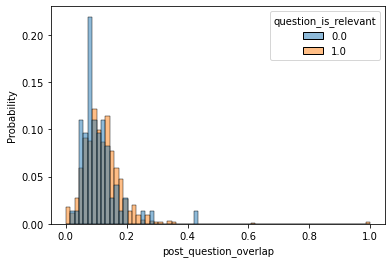

In [45]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# valid_var = 'question_is_valid'
valid_var = 'question_is_relevant'
post_question_overlap_score_data = pd.melt(clean_question_label_data.loc[:, ['post_question_overlap_score', valid_var]], id_vars=valid_var, value_name='post_question_overlap')
sns.histplot(x='post_question_overlap', data=post_question_overlap_score_data, hue=valid_var, stat='probability', common_norm=False)
plt.show()
# normalize, bin plots
# bin_count = 20
# score_bins = np.histogram(clean_question_label_data.loc[:, 'post_question_overlap_score'], bin_count)[1]
# valid_question_score_bin_counts = np.histogram(clean_question_label_data.loc[:, 'post_question_overlap_score'], bins=score_bins)[0]
# valid_question_score_bin_counts = valid_question_score_bin_counts / valid_question_score_bin_counts.sum()
# print(valid_question_score_bin_counts)
# # plt.hist(, bins=score_bins, alpha=0.5)
# # plt.show()
# # # plt.show()

OK! It looks like relevant questions do indeed have higher overlap, so let's take a high percentile of the "relevant" distribution as the cutoff.

In [46]:
score_cutoff_pct = 50
relevant_question_label_data = clean_question_label_data[clean_question_label_data.loc[:, valid_var]==1].loc[:, 'post_question_overlap_score']
question_post_overlap_score_cutoff = np.percentile(relevant_question_label_data, score_cutoff_pct)
print(f'score cutoff = {"{:1.3f}".format(question_post_overlap_score_cutoff)}')
# compute precision/recall
print(f'recall = {len(relevant_question_label_data[relevant_question_label_data >= question_post_overlap_score_cutoff])/len(relevant_question_label_data)}')
print(f'precision = {len(relevant_question_label_data[relevant_question_label_data >= question_post_overlap_score_cutoff])/len(clean_question_label_data[clean_question_label_data.loc[:, "post_question_overlap_score"] >= question_post_overlap_score_cutoff])}')

score cutoff = 0.114
recall = 0.5011160714285714
precision = 0.9432773109243697


Next: let's identify the top question words associated with clarification questions.

In [47]:
# first words
clarification_var = 'question_is_clarification'
clean_question_label_data = clean_question_label_data.assign(**{
    'question_first_word' : clean_question_label_data.loc[:, 'question'].apply(lambda x: word_tokenizer.tokenize(x)[0].lower())
})
first_word_in_question_counts = clean_question_label_data.loc[:, 'question_first_word'].value_counts()
valid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==1].loc[:, 'question_first_word'].value_counts()
invalid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==0].loc[:, 'question_first_word'].value_counts()
# normalize counts
valid_question_first_word_counts = valid_question_first_word_counts / valid_question_first_word_counts.sum()
invalid_question_first_word_counts = invalid_question_first_word_counts / invalid_question_first_word_counts.sum()
valid_question_first_word_ratio = (valid_question_first_word_counts / invalid_question_first_word_counts).dropna()
valid_question_first_word_ratio.sort_values(inplace=True, ascending=False)
print(valid_question_first_word_ratio[valid_question_first_word_ratio > 1.])
print(valid_question_first_word_ratio[valid_question_first_word_ratio < 1.])

info     12.086093
does     10.273179
did       3.798486
what      3.122241
also      3.021523
how       3.021523
were      3.021523
are       2.643833
do        2.618653
was       2.417219
where     2.417219
is        1.544334
when      1.510762
first     1.208609
wait      1.208609
well      1.208609
sorry     1.208609
which     1.208609
with      1.208609
Name: question_first_word, dtype: float64
so         0.949622
why        0.922360
have       0.776963
could      0.755381
can        0.690634
i          0.667916
who        0.604305
your       0.604305
this       0.604305
there      0.604305
*          0.604305
just       0.604305
ok         0.604305
lol        0.604305
ask        0.604305
her        0.604305
depends    0.604305
would      0.503587
it         0.483444
the        0.362583
don        0.302152
and        0.302152
esh        0.302152
he         0.302152
if         0.302152
let        0.302152
nta        0.274684
you        0.251794
didn       0.201435
yta        0.1648

Clarification questions tend to ask questions with concrete details ex. `how`, `what`, `where`, `which`, `info` (common in AITA). Non-clarification questions mention more subjective questions ex. `why`, `could`, `who`, `maybe`, `didn`.

Let's re-run this after parsing the questions to get the root words.

In [48]:
import spacy
nlp_pipeline = spacy.load('en_core_web_sm')

In [49]:
def extract_question_word(parse, 
                          question_dep=['advmod','attr','dobj','aux','nsubj'],
                          question_word_POS=['PRON','ADV','VERB', 'AUX']):
    # get sentence containing question
    sentence = list(filter(lambda x: x[-1].text=='?', parse.sents))[0]
    root_word = sentence.root
    root_children = list(root_word.children)
    question_candidates = list(filter(lambda x: x.dep_ in question_dep and x.pos_ in question_word_POS, root_children))
    # heuristic: get the first one in the sequence
    if(len(question_candidates) > 0):
        question_word = question_candidates[0].text.lower()
    else:
#         print(f'no candidate in sentence {sentence}')
        question_word = root_word.text.lower()
    return question_word
test_sent = 'when did you tell her to do that?'
test_parse = nlp_pipeline(test_sent)
test_parse_sent = list(test_parse.sents)[0]
print(extract_question_word(test_parse))

when


In [50]:
clean_question_label_data = clean_question_label_data.assign(**{
    'question_parse' : clean_question_label_data.loc[:, 'question'].apply(lambda x: nlp_pipeline(x))
})
clean_question_label_data = clean_question_label_data.assign(**{
    'question_parse_first_word' : clean_question_label_data.loc[:, 'question_parse'].apply(lambda x: extract_question_word(x))
})

In [51]:
display(clean_question_label_data.loc[:, 'question_parse_first_word'].value_counts().head(10))

what    77
you     74
do      72
is      67
did     66
why     64
i       44
are     43
have    41
does    32
Name: question_parse_first_word, dtype: int64

In [52]:
## compute ratios
valid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==1].loc[:, 'question_parse_first_word'].value_counts()
invalid_question_first_word_counts = clean_question_label_data[clean_question_label_data.loc[:, clarification_var]==0].loc[:, 'question_parse_first_word'].value_counts()
valid_question_first_word_counts = valid_question_first_word_counts / valid_question_first_word_counts.sum()
invalid_question_first_word_counts = invalid_question_first_word_counts / invalid_question_first_word_counts.sum()
valid_question_first_word_ratio = (valid_question_first_word_counts / invalid_question_first_word_counts).dropna()
valid_question_first_word_ratio.sort_values(inplace=True, ascending=False)
print(valid_question_first_word_ratio[valid_question_first_word_ratio > 1.])
print(valid_question_first_word_ratio[valid_question_first_word_ratio < 1.])

does     5.841611
long     5.438742
also     3.625828
are      3.107852
where    3.021523
were     3.021523
what     2.975038
did      2.463704
do       1.955103
first    1.812914
is       1.645052
there    1.208609
then     1.208609
so       1.057533
you      1.051938
was      1.007174
will     1.007174
Name: question_parse_first_word, dtype: float64
it            0.906457
how           0.846026
why           0.828121
can           0.776963
she           0.755381
have          0.699721
when          0.604305
could         0.604305
definitely    0.604305
everyone      0.604305
let           0.604305
that          0.604305
right         0.604305
nta           0.604305
question      0.604305
i             0.551756
he            0.258988
who           0.258988
would         0.248831
they          0.201435
should        0.151076
Name: question_parse_first_word, dtype: float64


Similar as before, the valid questions have concrete question words like `what`, `does`, `where`, `was`; invalid questions have more subjective words like `why`, `how`, `could`, `should`.

### Bootstrap from "INFO" comments
We noticed in the `AmItheAsshole` comments that some questions are marked with `INFO`. Can we use these questions to bootstrap a classifier that automatically identifies clarification questions?

In [1]:
## reload question data
import pandas as pd
from ast import literal_eval
import numpy as np
question_comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_question_data_for_validity_check.gz', sep='\t', compression='gzip', index_col=False)
question_comment_data.drop('Unnamed: 0', axis=1, inplace=True)
question_comment_data = question_comment_data[~question_comment_data.loc[:, 'questions'].apply(lambda x: type(x) is float and np.isnan(x))]
# convert question list
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(literal_eval)
})
display(question_comment_data.head())
## remove quote questions
import re
quote_matcher = re.compile('&gt;[^\n]+\n')
question_comment_data = question_comment_data.assign(**{
    'questions' : question_comment_data.loc[:, 'questions'].apply(lambda x: list(filter(lambda y: quote_matcher.search(y) is None, x)))
})
question_comment_data = question_comment_data.assign(**{
    'question' : question_comment_data.loc[:, 'questions'].apply(lambda x: x[0] if len(x) > 0 else '')
})
print(f'{question_comment_data[question_comment_data.loc[:, "question"]!=""].shape[0]}/{question_comment_data.shape[0]} valid questions')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (0,5,9,11,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,author,author_flair_text,author_fullname,body,created_utc,edited,id,parent_id,score,subreddit,parent_created,parent_text,parent_title,parent_edited,parent_author,questions,question_occurs_post_initial
0,grumpypantsoldman,NaN,t2_27ps6lxw,NTA. I think you dodged a bullet. Who needs a ...,1541030405,False,e8tkic1,9t3n27,14,AmItheAsshole,1541024836,TL;DR: Ran into ex. We organized to catch up. ...,"AITA, for asking an ex girlfriend why she woul...",False,HashedGaming,[Who needs a crazy person in their lives?],False
1,unknown_salmon,NaN,t2_q57txtp,I do feel for you. Do you think you could be b...,1541030426,False,e8tkj26,9t1u2e,2,Advice,1541012933,How do I deal with all these fake/fabricated p...,I've been struggling a lot lately and I need a...,False,mosorosso,[Do you think you could be bothered to have a ...,False
2,jon_lfl,NaN,t2_20q10ghp,I have not seen my insurance package for this ...,1541045930,False,e8tywqp,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Or are these insurance prices common practices?],False
3,omicron7e,NaN,t2_3cx76,&gt;matching industry trends\n\nEveryone else ...,1541073519,False,e8udnb2,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Why aren't we?],False
4,JesyouJesmeJesus,NaN,t2_hhyv3,"Could stick with my same high deductible plan,...",1541076018,False,e8ufm7h,9t2e8e,1,personalfinance,1541016597,Just wanted to get a general feeling of what o...,General Benefits Discussion/2019 Open Enrollment,1541022607,Smearwashere,[Is there a downside I’m not seeing with this ...,False


873188/873188 valid questions


In [2]:
info_question_matcher = re.compile('^INFO')
question_comment_data = question_comment_data.assign(**{
    'info_question' : question_comment_data.loc[:, 'question'].apply(lambda x: info_question_matcher.search(x) is not None)
})
info_question_comment_data = question_comment_data[question_comment_data.loc[:, 'info_question']]
print(f'{info_question_comment_data.shape[0]}/{question_comment_data.shape[0]}')
display(info_question_comment_data.loc[:, 'question'].iloc[:10].values)

22693/873188


array(['INFO What was her reaction to that ultimatum?',
       'INFO Would you, in the same monetary position as her, be willing to buy her a computer if she needed it?',
       'INFO - did you pay for the car?',
       'INFO - (sorry, revised my judgement) - Was this something you had long planned out with your mother?',
       'INFO - are you “that guy” that falls asleep whenever they sit still for 20 minutes or did you do this to avoid dinner?',
       "INFO - Is there some reason they both can't be there?",
       "INFO what reactions did you get when you told them you're 14?",
       'INFO, how old are you guys?',
       "INFO Depends how it was brought up, but since there are two games- one the husband was already a part of and one the wife just joined, why don't they just play one game each and the other watches the baby on the others turn?",
       'INFO--did he tell you you were getting paid, or did you just assume?'],
      dtype=object)

Let's use this data as gold labels for "true" clarification questions and the non-info questions as silver labels for non-clarification questions, then try to classify using some standard models.

In [3]:
## sample non-info questions
np.random.seed(123)
non_info_question_comment_data = question_comment_data[~question_comment_data.loc[:, 'info_question']]
info_question_sample_size = info_question_comment_data.shape[0]
non_info_question_comment_data = non_info_question_comment_data.loc[np.random.choice(non_info_question_comment_data.index, info_question_sample_size, replace=False), :]

In [4]:
## combined text data
info_question_comment_text = np.hstack(
    [info_question_comment_data.loc[:, 'question'].values,
     non_info_question_comment_data.loc[:, 'question'].values]
)
# remove "INFO" as word
import re
info_matcher = re.compile('^INFO:?')
info_matcher_func = np.vectorize(lambda x: info_matcher.sub('', x))
info_question_comment_text = info_matcher_func(info_question_comment_text)
print(info_question_comment_text.shape)

(45386,)


In [5]:
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
en_stops = set(get_stop_words('en'))
question_words = {'who', 'what', 'when', 'where', 'why', 'how', 'is', 'are', 'do', 'did', 'would', 'could', 'should'}
punct_words = set('"?$%\'()*,-./’')
en_stops = en_stops - question_words
en_stops = en_stops | punct_words
en_stops = en_stops
tokenizer = WordPunctTokenizer()
max_vocab_size = 1000
cv = CountVectorizer(max_features=max_vocab_size, stop_words=en_stops, tokenizer=tokenizer.tokenize)
info_question_dtm = cv.fit_transform(info_question_comment_text)
## get vocab
info_question_word_counts = pd.Series(np.array(info_question_dtm.sum(axis=0))[0], index=list(sorted(cv.vocabulary_, key=cv.vocabulary_.get))).sort_values(inplace=False, ascending=False)
print(info_question_word_counts.head(20))

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'how', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'what', 'when', 'where', 'who', 'why', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


is       9902
what     7601
do       7285
are      7084
how      6035
did      5920
t        4927
why      4864
s        3965
would    3122
can      2963
just     2344
get      1971
when     1965
like     1909
know     1767
want     1615
who      1481
re       1448
say      1309
dtype: int64


Great! Now let's split into train/test and see how well we can identify clarification questions.

In [6]:
train_pct = 0.8
info_question_labels = np.array([0,]*len(info_question_comment_data) + [1,]*len(non_info_question_comment_data))
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from tqdm import tqdm
def train_test_model(X, Y, train_idx, test_idx, model):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    ## train model
    model.fit(X_train, Y_train)
    ## test model
    Y_pred = model.predict(X_test)
    model_score = f1_score(Y_test, Y_pred)
    return model_score
np.random.seed(123)
n_folds = 10
k_fold = StratifiedKFold(n_folds, shuffle=True)
models = [
    LogisticRegression(penalty='l2', max_iter=1000),
    # removed MLP because of high training time lol
#     MLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate_init=1e-3, max_iter=1000),
    SVC(C=1., degree=3, max_iter=1000),
    RandomForestClassifier(n_estimators=100),
]
for model in models:
    print(f'testing model {type(model)}')
    info_question_label_acc = []
    for train_idx, test_idx in tqdm(k_fold.split(info_question_dtm, info_question_labels)):
        score_k = train_test_model(info_question_dtm, info_question_labels, train_idx, test_idx, model)
    #     X_train, X_test = info_question_dtm[train_idx], info_question_dtm[test_idx]
    #     Y_train, Y_test = info_question_labels[train_idx], info_question_labels[test_idx]
    #     ## train model
    #     model.fit(X_train, Y_train)
    #     ## test model
    #     Y_pred = model.predict(X_test)
    #     model_score = f1_score(Y_test, Y_pred)
        info_question_label_acc.append(score_k)
    print(f'mean F1 = {np.mean(info_question_label_acc)} +/- {np.std(info_question_label_acc)}')

0it [00:00, ?it/s]

testing model <class 'sklearn.linear_model._logistic.LogisticRegression'>


10it [00:10,  1.08s/it]
0it [00:00, ?it/s]

mean F1 = 0.697964820110219 +/- 0.009397922369227825
testing model <class 'sklearn.svm._classes.SVC'>


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
1it [00:18, 18.81s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
2it [00:37, 18.88s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
3it [00:56, 18.87s/it]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: Converge

mean F1 = 0.46557234175788426 +/- 0.03912339250706374
testing model <class 'sklearn.ensemble._forest.RandomForestClassifier'>


10it [13:24, 80.40s/it]

mean F1 = 0.6988896779106252 +/- 0.007685303205787419


These scores are fine but not great. Let's see how they do on the hand-labeled data.

In [ ]:
## load labelled data
## load all previously labeled data
question_only_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_question_labels.tsv', sep='\t', index_col=False)
question_initial_comment_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_post_initial_question_labels.tsv', sep='\t', index_col=False)
parent_reply_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_parent_reply_question_labels.tsv', sep='\t', index_col=False)
no_filter_question_label_data = pd.read_csv('../../data/reddit_data/sample_advice_subreddit_no_filter_question_labels.tsv', sep='\t', index_col=False)
combined_question_label_data = pd.concat([
    question_only_comment_label_data,
    question_initial_comment_label_data,
    parent_reply_question_label_data,
    no_filter_question_label_data,
], axis=0)
label_cols = ['question_is_relevant', 'question_is_clarification', 'submission_contains_answer']
combined_question_label_data.fillna({x : 0. for x in label_cols}, inplace=True)
text_cols = ['selftext', 'parent_text', 'question']
combined_question_label_data.fillna({x : '' for x in text_cols}, inplace=True)
# fix inconsistent columns
combined_question_label_data = combined_question_label_data.assign(**{
    'submission_contains_answer' : combined_question_label_data.loc[:, 'submission_contains_answer']+combined_question_label_data.loc[:, 'post_contains_answer']
})
combined_question_label_data = combined_question_label_data.assign(**{
    'selftext' : combined_question_label_data.loc[:, 'selftext'].astype(str) + combined_question_label_data.loc[:, 'parent_text'].astype(str)
})
combined_question_label_data = combined_question_label_data.assign(**{
    'question' : combined_question_label_data.apply(lambda x: x.loc['question'] if x.loc['question']!='' else x.loc['body'], axis=1)
})
## remove bot authors
bot_authors = ['LocationBot']
combined_question_label_data = pd.merge(combined_question_label_data, question_comment_data.loc[:, ['id', 'author']], on='id')
combined_question_label_data = combined_question_label_data[~combined_question_label_data.loc[:, 'author'].isin(bot_authors)]
for label_col in label_cols:
    print(combined_question_label_data.loc[:, label_col].value_counts())
## compute validity
combined_question_label_data = combined_question_label_data.assign(**{
    'question_is_valid' : ((combined_question_label_data.loc[:, 'question_is_relevant']==1) & 
                           (combined_question_label_data.loc[:, 'question_is_clarification']==1) & 
                           (combined_question_label_data.loc[:, 'submission_contains_answer']==0)).astype(int)
})